In [1]:
%pylab inline

from typing import Callable, Sequence, Tuple, Optional
from random import sample

from sklearn.linear_model import LogisticRegression
from scipy.stats import multivariate_normal, ortho_group
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set_style("white")
colors = sns.color_palette(n_colors=10)

# Sample 2d data from two Gaussians

The means are chosen to make the data is linearly separable.

- Move the gaussians closer together to see how active learning would deal with non-linearly separable data.
- Play with the seeds to get different shapes of the gaussians.

In [3]:
def sample_covar(dim: int = 2, scale_min: float =  .3, scale_max: float = 5) -> np.ndarray:
  """Construct random covariance matrix by sampling a rotation and scale matrix."""
  R = ortho_group.rvs(dim) * (rand(dim, dim) * (scale_max - scale_min) + scale_min)
  return R.dot(R.T)

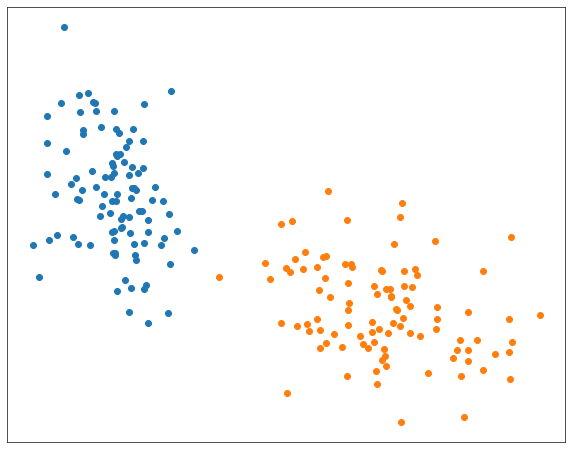

In [4]:
N_1, N_2 = 100, 100  # number of samples in each point cloud
mu_1 = [-5, 2]  # centroid of the first point cloud
mu_2 = [5, -2]  # centroid of the second point cloud

random.seed(23)

X = np.concatenate([
  multivariate_normal(mu_1, sample_covar()).rvs(N_1),
  multivariate_normal(mu_2, sample_covar()).rvs(N_2),
])
y = np.concatenate([zeros(N_1, int), ones(N_2, int)])

# show a scatter plot of the data
figure(figsize=(10,8))
scatter(X[y==0, 0], X[y==0, 1], color=colors[0])
scatter(X[y==1, 0], X[y==1, 1], color=colors[1])
xticks(()), yticks(());

## Helper functions for plotting data and classifier

In [5]:
def meshgrid_from_bounds(lower_left: Sequence[float], upper_right: Sequence[float], *,
                         resolution: float = 0.02) -> Tuple[np.ndarray, np.ndarray]:
  """Return a meshgrid that covers the range from lower_left to upper_right."""
  return meshgrid(arange(lower_left[0], upper_right[0], resolution),
                  arange(lower_left[1], upper_right[1], resolution))

def plot_decision_boundary(clf, lower_left: Sequence[float], upper_right: Sequence[float], *,
                           resolution: float = 0.02, boundary_color: Tuple[float] = (0.2, 0.2, 0.2)):
  """Plot decision boundary of a given classifier in the given range.
  
     Args:
        clf: The classifier to evaluate.
        lower_left: Lower left coordinate of the plotting range.
        upper_right: Upper right coordinate of the plotting range.
  """
  xx, yy = meshgrid_from_bounds(lower_left, upper_right, resolution=resolution)
  Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0].reshape(xx.shape)
  contour(xx, yy, Z, levels=[0.5], colors=[boundary_color])

def lighten(color: Tuple[float], *, amount: float = .6):
  """Blend color with white by the given amount."""
  return tuple(array(color) * (1 - amount) + array([1, 1, 1]) * amount)

In [6]:
def plot_data(X: np.ndarray, y: np.ndarray, train_idx: Sequence[int], *,
              colors: Sequence[Tuple[float]] = sns.color_palette(n_colors=2)):
  """Scatter plot of the training and unlabeled data.

     Args:
        X, y: Data and associated labels.
        train_idx: Indices of the training data.
        colors: Plotting colors of the two classes."""
  # show all data
  scatter(X[y==0, 0], X[y==0, 1], color=lighten(colors[0]), s=6)
  scatter(X[y==1, 0], X[y==1, 1], color=lighten(colors[1]), s=6)

  # show training data
  X_tr = X[train_idx]
  y_tr = y[train_idx]
  scatter(X_tr[y_tr==0, 0], X_tr[y_tr==0, 1], color=colors[0])
  scatter(X_tr[y_tr==1, 0], X_tr[y_tr==1, 1], color=colors[1])
  xticks(()), yticks(());

def plot_data_and_classifier(X: np.ndarray, y: np.ndarray, train_idx: Sequence[int], clf, *,
                             previous_clf=None, colors: Sequence[Tuple[float]] = sns.color_palette(n_colors=2)):
  """Scatter plot of the training and unlabeled data and the decision boundary of the classifier.

     Also draws decsion boundary of the classifier from the previous round (if given).

     Args:
        X, y: Data and associated labels.
        train_idx: Indices of the training data.
        clf: Classifier trained on training data.
        pervious_clf: Classifier trained on training data in the last round.
        colors: Plotting colors of the two classes.
  """
  if previous_clf is not None:
    plot_decision_boundary(previous_clf, lower_left=X.min(axis=0) - 1, upper_right=X.max(axis=0) + 1, boundary_color=(0.7, 0.7, 0.7))

  plot_decision_boundary(clf, lower_left=X.min(axis=0) - 1, upper_right=X.max(axis=0) + 1)
  plot_data(X, y, train_idx, colors=colors)


## Non-active learning

Train a logistic regression classifier on 10 randomly sampled training examples.

**Note:** we cherry-picked an example where the training went wrong - play with the seed (or remove it) to see different results.


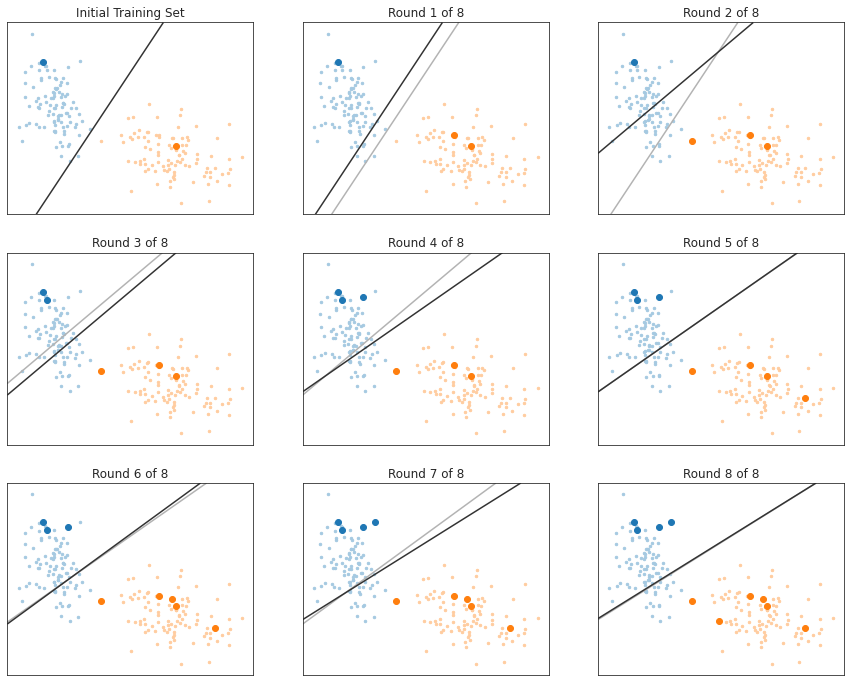

In [7]:
random.seed(112818)  # cherry-pick a seed of a bad example

# start with one sample from either class
starting_samples = [choice(range(N_1)), N_1 + choice(range(N_2))]
train_idx = starting_samples[:]
clf = LogisticRegression().fit(X[train_idx], y[train_idx])

# ...  and randomly sample 8 additional training samples
figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_data_and_classifier(X, y, train_idx, clf)

for round in range(8):
  new_sample = choice([i for i in range(N_1 + N_2) if i not in train_idx])
  train_idx.append(new_sample)
  previous_clf = clf
  clf = LogisticRegression().fit(X[train_idx], y[train_idx])
  
  ax = subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  plot_data_and_classifier(X, y, train_idx, clf, previous_clf=previous_clf)

## Active learning with uncertainty sampling

Starting with one sample from either class as above, iteratively get the label of a sample where the model is most uncertain about the class until 10 samples are drawn.

In [8]:
from scipy.stats import entropy

def least_confidence(posterior: np.ndarray) -> np.ndarray:
  """Least confidence criterion, u(x) = 1 - max P(y | x).

     Args:
        posterior: Estimated class probabilities - ndarray of shape (n_samples, n_classes).
    
     Returns:
        Least-confidence score.
  """
  return 1 - posterior.max(axis=1)


def minimum_margin(posterior: np.ndarray) -> np.ndarray:
  """Minumum margin criterion, u(x) = P(y_2* | x) - P(y_1* | x), where y_1* and y_2* are the two most probable classes.

     Args:
        posterior: Estimated class probabilities - ndarray of shape (n_samples, n_classes).
    
     Returns:
        Minumum margin score.
  """
  most_probable = posterior.max(axis=1)
  # hack to get the second highest posterior probability
  mask_most_probable = (posterior == most_probable.reshape(-1, 1))
  second_most_probable = (posterior - mask_most_probable).max(axis=1)
  return second_most_probable - most_probable


def entropy_criterion(posterior: np.ndarray) -> np.ndarray:
  """Entropy criterion, u(x) = -E[log P(y | x)].

     Args:
        posterior: Estimated class probabilities - ndarray of shape (n_samples, n_classes).
    
     Returns:
        Entropy of the posterior distribution.
  """
  return entropy(posterior, axis=1)


def uncertainty_sampling(clf, X: np.ndarray, train_idx: Sequence[int], criterion: Callable[[np.ndarray], np.ndarray]) -> int:
  """Get the index of an unknown sample where the classifier is most uncertain about the label.

     Args:
        clf: The classifier (must provide `predict_proba()`).
        X: All data (labeled and unlabeled) - ndarray of shape (n_samples, n_features).
        train_idx: Indices of the training samples.
        criterion: Sample utility that maps posterior class probabilities to sample utility.

     Returns:
        Index of the sample in X with the highest decision uncertainty that is not yet in `train_idx`.
  """
  unknown_indices = array([i for i in range(X.shape[0]) if i not in train_idx])
  posterior = clf.predict_proba(X[unknown_indices])
  utility = criterion(posterior)
  return unknown_indices[argmax(utility)]

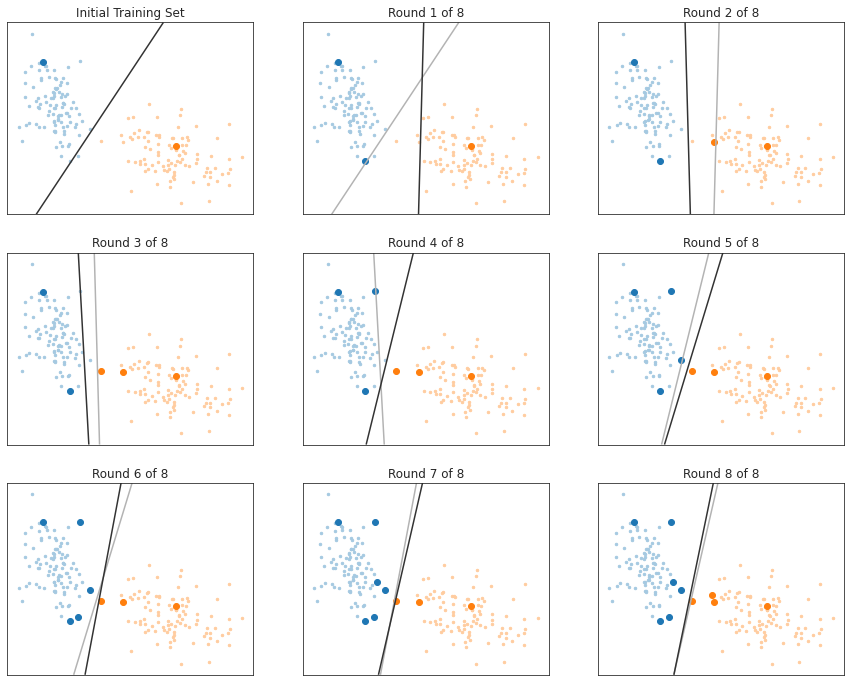

In [9]:
# starting with the sample samples as above ...
train_idx = starting_samples[:]
clf = LogisticRegression().fit(X[train_idx], y[train_idx])

figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_data_and_classifier(X, y, train_idx, clf)

# ... do 8 rounds of uncertainty sampling
for round in range(8):
  new_sample = uncertainty_sampling(clf, X, train_idx, criterion=entropy_criterion)
  train_idx.append(new_sample)

  subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  previous_clf = clf
  clf = LogisticRegression().fit(X[train_idx], y[train_idx])
  plot_data_and_classifier(X, y, train_idx, clf, previous_clf=previous_clf)

## Query-by-committee

In [10]:
def get_ensemble_votes(ensemble, X: np.ndarray, n_classes) -> np.ndarray:
  """Returns the ensemble votes for each feature in X."""
  predictions = ensemble._predict(X)
  return np.apply_along_axis(np.bincount, axis=1, arr=predictions, minlength=n_classes)

def plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx):
  xx, yy = meshgrid_from_bounds(X.min(0) - 1, X.max(0) + 1)

  try:
    proba = ensemble.predict_proba(np.c_[xx.ravel(), yy.ravel()])
  except AttributeError:
    votes = get_ensemble_votes(ensemble, np.c_[xx.ravel(), yy.ravel()], n_classes=len(np.unique(y)))
    proba = (votes / len(ensemble.estimators))

  contour(xx, yy, proba[:, 0].reshape(xx.shape), levels=[0.5])
  plot_data(X, y, train_idx)

### Vote entropy

Query label for the sample that maximizes $u(\mathbf x) = -\sum_y\frac{V(y)}{C}\log\frac{V(y)}{C}$.

$V(y)$ are the number of votes for class $y$ and $C$ is the number of classifiers in the ensemble.

In [11]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [12]:
def vote_entropy(ensemble: VotingClassifier, X: np.ndarray, train_idx: Sequence[int], n_classes: int) -> int:
  unknown_indices = array([i for i in range(X.shape[0]) if i not in train_idx])
  votes = get_ensemble_votes(ensemble, X[unknown_indices], n_classes=n_classes)
  utility = entropy(votes / len(ensemble.estimators), axis=1)
  return unknown_indices[argmax(utility)]

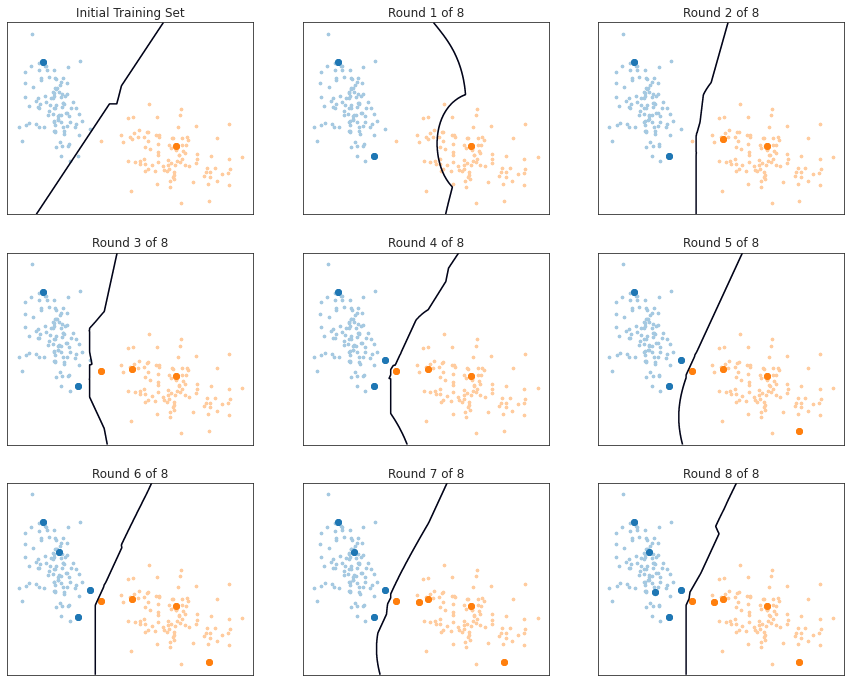

In [13]:
train_idx = starting_samples[:]
ensemble = VotingClassifier([
  ('linear svm', LinearSVC(dual=False)),
  ('rbf svm', SVC()),
  ('poly svm', SVC(kernel='poly')),
  ('decision tree', DecisionTreeClassifier()),
  ('passive agressive', PassiveAggressiveClassifier()),
  ('naive bayes', GaussianNB()),
  ('knn', KNeighborsClassifier(n_neighbors=2))
], voting='hard').fit(X[train_idx], y[train_idx])

figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
plot_data(X, y, train_idx)

for round in range(8):
  new_sample = vote_entropy(ensemble, X, train_idx, n_classes=2)
  train_idx.append(new_sample)

  subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  ensemble = ensemble.fit(X[train_idx], y[train_idx])
  plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
  plot_data(X, y, train_idx)

### Consensus entropy

Query label for the sample that maximizes $u(\mathbf x) = -\sum_y\overline P(y|\mathbf x)\log \overline P(y|\mathbf x)$.

$\overline P(y|\mathbf x) = \frac{1}{C} \sum_{h_i \in \mathcal C} \hat P_i(y|\mathbf x)$ is the consensus probability of the class $y$ and $\hat P_i(y|\mathbf x)$ is the posterior class probability estimate of the classifier $h_i$ in the ensemble $\mathcal C$.

In [14]:
def consensus_entropy(ensemble: VotingClassifier, X: np.ndarray, train_idx: Sequence[int]) -> int:
  unknown_indices = array([i for i in range(X.shape[0]) if i not in train_idx])
  probas = ensemble.predict_proba(X[unknown_indices])
  utility = entropy(probas, axis=1)
  return unknown_indices[argmax(utility)]

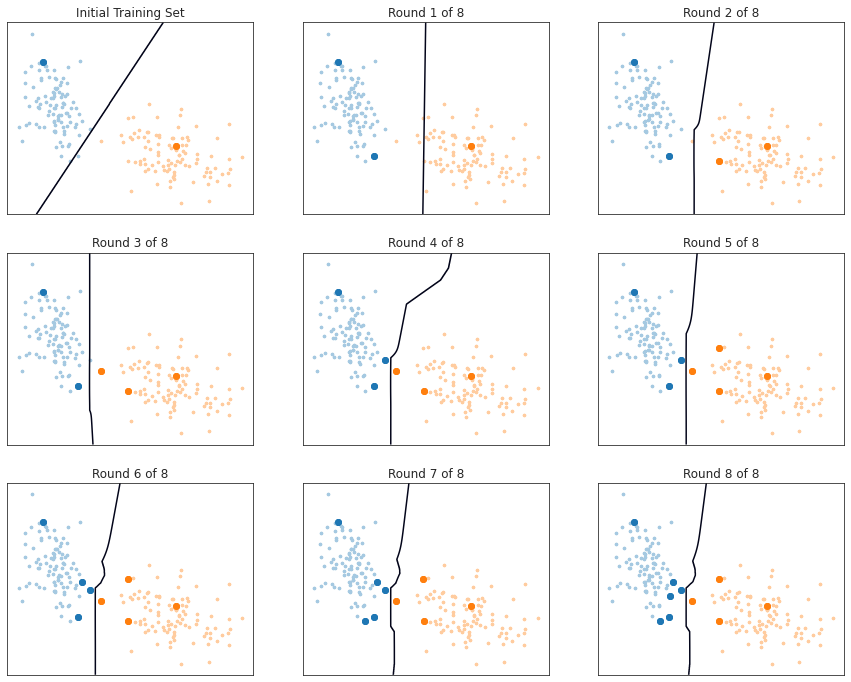

In [15]:
train_idx = starting_samples[:]
ensemble = VotingClassifier([
  ('logistic regression', LogisticRegression()),
  ('decision tree', DecisionTreeClassifier()),
  ('naive bayes', GaussianNB()),
  ('knn', KNeighborsClassifier(n_neighbors=2))
], voting='soft').fit(X[train_idx], y[train_idx])

figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
plot_data(X, y, train_idx)

for round in range(8):
  new_sample = consensus_entropy(ensemble, X, train_idx)
  train_idx.append(new_sample)

  subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  ensemble = ensemble.fit(X[train_idx], y[train_idx])
  plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
  plot_data(X, y, train_idx)

### Maxiumum Disagreement

Query label for the sample that maximizes $u(\mathbf x) = \sum_{h_i \in \mathcal C} D_{\text{KL}}(\hat P_i \| \overline P)$, i.e., where the average Kullback Leibler Divergence between committee members and the consensus is largests.

In [16]:
def max_disagreement(ensemble: VotingClassifier, X: np.ndarray, train_idx: Sequence[int]) -> int:
  unknown_indices = array([i for i in range(X.shape[0]) if i not in train_idx])
  
  probas = ensemble._collect_probas(X[unknown_indices])
  consensus = np.mean(probas, axis=0)
  utility = array([
       np.apply_along_axis(entropy, axis=1, arr=probas[:, i], qk=qk).sum()
       for i, qk in enumerate(consensus)
  ])

  return unknown_indices[argmax(utility)]

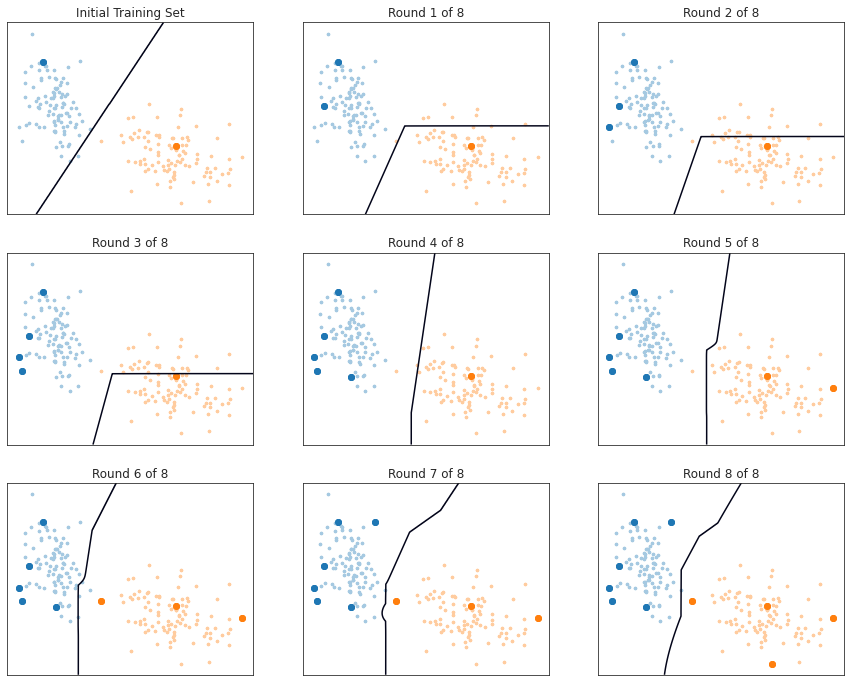

In [17]:
train_idx = starting_samples[:]
ensemble = VotingClassifier([
  ('logistic regression', LogisticRegression()),
  ('decision tree', DecisionTreeClassifier()),
  ('naive bayes', GaussianNB()),
  ('knn', KNeighborsClassifier(n_neighbors=2))
], voting='soft').fit(X[train_idx], y[train_idx])

figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
plot_data(X, y, train_idx)

for round in range(8):
  new_sample = max_disagreement(ensemble, X, train_idx)
  train_idx.append(new_sample)

  subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  ensemble = ensemble.fit(X[train_idx], y[train_idx])
  plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
  plot_data(X, y, train_idx)

## Expected Model Change

We implement gradient descent on a toy model to have easy access to the gradient. With $\mathbf x = (x, y)$ and $\mathbf w = (b, w_1, w_2, w_3, w_4)$, we use a polynomial model,

$$h(\mathbf x; \mathbf w) = (1, x, y, x^2, y^2)\, \mathbf w = (w_1, w_2) \mathbf x + (w_3, w_4) \mathbf x^2 + b,$$

where $\mathbf x^2$ is element-wise exponentiation. We use a Hinge-Loss as our loss function:
$$\ell (h; \mathcal L) = \!\!\!\!\!\sum_{(\mathbf x_n, y_n) \in \mathcal L}\!\!\!\! \max\left(0, 1 - h(\mathbf x_n; \mathbf w)\cdot y_n\right)$$

We could compute the gradient ourselves, but why bother, when we can use  automatic differentiation (provided by [JAX](https://github.com/google/jax)) instead?

In [18]:
from jax import grad
import jax.numpy as jnp

class PolynomialModel:
  """Simple polynomial binary classification model (see text above).

     Uses gradient descent for training.

     Args:
        order: The order of the polynomial expansion of the feature vector
  """
  def __init__(self, order: int = 2):
    self.order_ = order
    self.w_ = None
    self.grad_loss_ = grad(self.loss_)

  def predict(self, X: np.ndarray) -> np.ndarray:
    """Get confidence values for the samples in X.

       Confidence is the distance to the decision boundary: positive confidence values
       mean class 1, negative values mean class 0.

       Args:
          X: Samples to classify. ndarray of shape (N_samples, N_features).
       
       Returns:
          ndarray of shape N_samples with confidence values.
    """
    return np.array(self.predict_(self.w_, self.order_, X))

  def predict_proba(self, X: np.ndarray) -> np.ndarray:
    """Quick and dirty mapping of the confidence value to a "probability estimate".

       This is most likely not a good estimate, because we don't optimize the appropriate
       loss function. If you want something better, have a look at scikit-learn's
       probability calibration.

       Args:
          X: Samples to classify. ndarray of shape (N_samples, N_features).

       Returns:
          ndarray of shape (2, N_samples) of class probability estimates.
    """
    p1 = 1 / (1 + np.exp(-self.predict(X)))
    return np.c_[1 - p1, p1]

  @staticmethod
  def predict_(w: np.ndarray, order: int, X: np.ndarray):
    """Decision function for use in the loss function"""
    return jnp.concatenate([np.ones((X.shape[0], 1))] + [X**(i+1) for i in range(order)], axis=1).dot(w)

  def loss(self, X: np.ndarray, y: np.ndarray):
    """Hinge loss of the samples X and true classes y.

       y is assumed to contain only the values 0 or 1.

       Args:
          X: Samples to classify. ndarray of shape (N_samples, N_features).
          y: Classification target. ndarray of shape (N_samples).

       Returns:
          Overall classification loss.
    """
    return float(self.loss_(self.w_, self.order_, X, y))

  def grad_loss(self, X: np.ndarray, y: np.ndarray):
    """Get the gradient of the loss function wrt the model parameters"""
    return np.array(self.grad_loss_(self.w_, self.order_, X, y))

  @classmethod
  def loss_(cls, w: np.ndarray, order: int, X: np.ndarray, y: np.ndarray):
    """Loss function for use in gradient descent"""
    y_scaled = 2 * np.array(y) - 1  # transform y from {0, 1} to {-1, 1}
    res = 1 - cls.predict_(w, order, X) * y_scaled
    return ((res > 0) * res).mean()

  def fit(self, X: np.ndarray, y: np.ndarray, *,
          learning_rate: float = 0.05,
          eps: float = 1e-5,
          max_iter: int = 1000,
          w_init: Optional[np.ndarray] = None):
    """Fit model parameters with gradient descent.

       Records losses during gradient descent in self.losses_.

       Args:
          X: Training samples. ndarray of shape (N_samples, N_features).
          y: Training labels. ndarray of shape (N_samples).
          learning_rate: Step size in each iteration.
          eps: Stop optimizing if loss changes less than this between iterations.
          max_iter: Maximum number of gradient descent iterations.
          w_init: Initial guess for the model parameter. Initialized with random values if set to None.
    """
    if w_init is None:
      self.w_ = randn(X.shape[1] * self.order_ + 1)
    else:
      assert w_init.shape == (X.shape[1] * self.order_ + 1, )
      self.w_ = w_init
    
    losses = [self.loss(X, y)]
    for _ in range(max_iter):
      dw = self.grad_loss(X, y)
      self.w_ -= learning_rate * dw

      losses.append(self.loss(X, y))
      if abs(losses[-1] - losses[-2]) < eps:
        break

    self.losses_ = np.array(losses)
    return self

In [19]:
def emc_sampling(clf: PolynomialModel, X: np.ndarray, train_idx: Sequence[int]) -> int:
  """Get the index of an unknown sample that maximizes the expected gradient length.

     We assume a binary classification problem.

     Args:
        clf: The classifier (must provide `grad_loss()`).
        X: All data (labeled and unlabeled) - ndarray of shape (n_samples, n_features).
        train_idx: Indices of the training samples.

     Returns:
        Index of the sample in X with the largest expected gradient of the loss function.
  """
  unknown_indices = array([i for i in range(X.shape[0]) if i not in train_idx])

  expected_grad_length = [
     get_expected_gradient_length(clf, X[[i]])
     for i in unknown_indices
  ]
  
  return unknown_indices[argmax(expected_grad_length)]

def get_expected_gradient_length(clf: PolynomialModel, x: np.ndarray) -> float:
  """Returns the expected value of the gradient length at x with respect to the class.

     We use our classifier to estimate the class probabilities, but we could have
     also just taken a simple average instead.
  """
  class_proba = clf.predict_proba(x)
  grad_if_class_zero = clf.grad_loss(x, [0])
  grad_if_class_one = clf.grad_loss(x, [1])
  return class_proba.dot(
      (np.linalg.norm(grad_if_class_zero),
       np.linalg.norm(grad_if_class_one)))[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


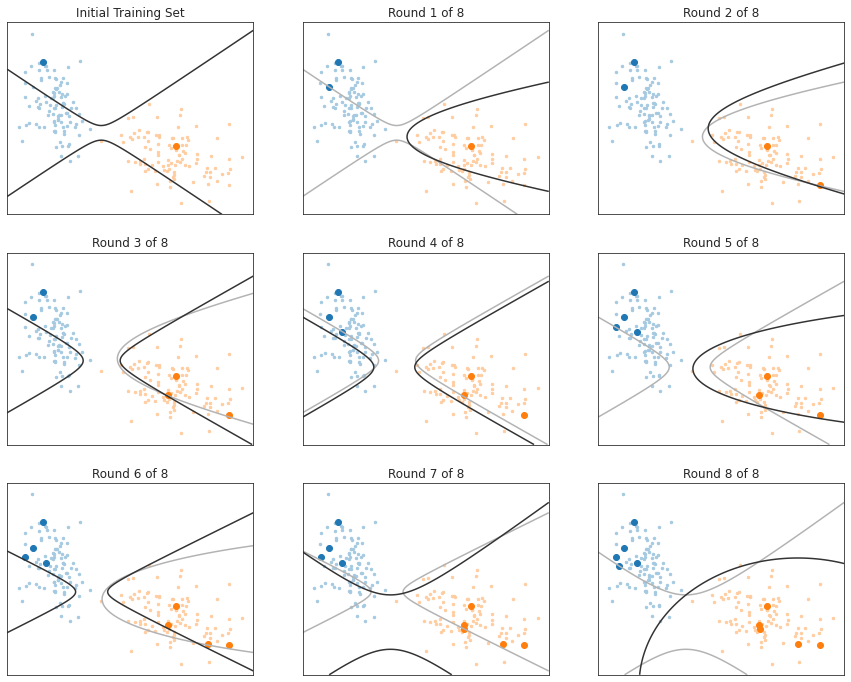

In [20]:
# starting with the sample samples as above ...
train_idx = starting_samples[:]
clf = PolynomialModel(2).fit(X[train_idx], y[train_idx])

figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_data_and_classifier(X, y, train_idx, clf)

# ... do 8 rounds of expected model change sampling
for round in range(8):
  new_sample = emc_sampling(clf, X, train_idx)
  train_idx.append(new_sample)

  subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  previous_clf = clf
  clf = PolynomialModel(2).fit(X[train_idx], y[train_idx])
  plot_data_and_classifier(X, y, train_idx, clf, previous_clf=previous_clf)

## Density weighting

Density weighting modifies a given utility function as $u'(\mathbf x) = u(\mathbf x)\hat p(\mathbf x)^\beta$. It can be used with any utility function - here we apply it to uncertainty sampling. To estimate the density, we use a kernel density with gaussian kernels.

Compared to the unweighted uncertainty sampling above, we select samples that are less close to the decision boundary, but in more dense regions of the feature space, which leads to even faster conversion.

In [21]:
def density_weighted_uncertainty_sampling(clf, X: np.ndarray, precomputed_density: np.ndarray, beta: float, train_idx: Sequence[int], criterion: Callable[[np.ndarray], np.ndarray]) -> int:
  """Uncertainty sampling with density weighting.

     Args:
        clf: The classifier (must provide `predict_proba()`).
        X: All data (labeled and unlabeled) - ndarray of shape (n_samples, n_features).
        precomputed_densiy: Sample density for all samples in X - ndarray of shape (n_samples).
        beta: Weighting parameter.
        train_idx: Indices of the training samples.
        criterion: Sample utility that maps posterior class probabilities to sample utility.

     Returns:
        Index of the sample in X with the highest decision uncertainty that is not yet in `train_idx`.
  """
  unknown_indices = array([i for i in range(X.shape[0]) if i not in train_idx])
  posterior = clf.predict_proba(X[unknown_indices])
  utility = precomputed_density[unknown_indices]**beta * criterion(posterior)
  return unknown_indices[argmax(utility)]

In [22]:
from sklearn.neighbors import KernelDensity
density = exp(KernelDensity().fit(X).score_samples(X))

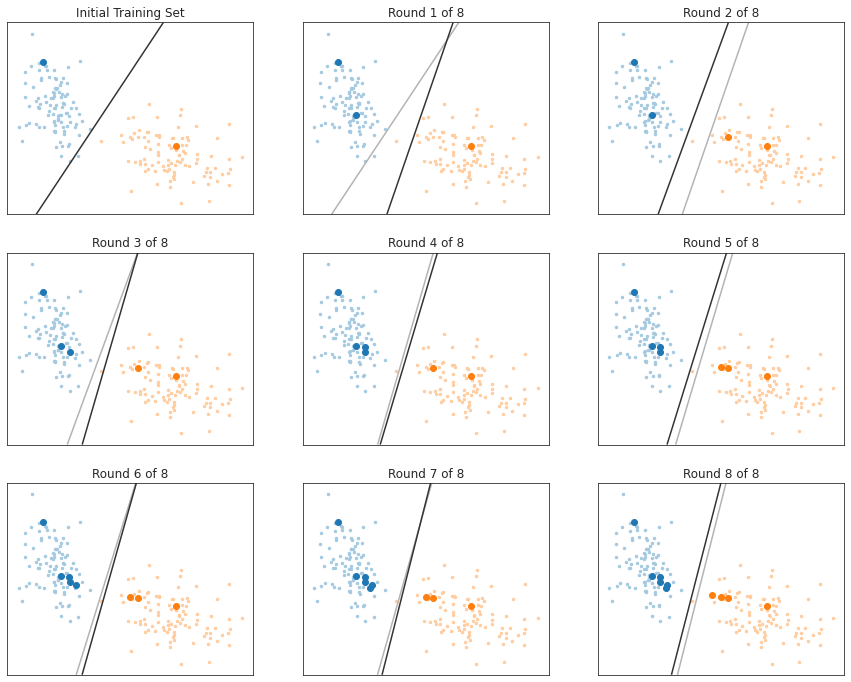

In [23]:
# starting with the sample samples as above ...
train_idx = starting_samples[:]
clf = LogisticRegression().fit(X[train_idx], y[train_idx])

figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_data_and_classifier(X, y, train_idx, clf)

# ... do 8 rounds of uncertainty sampling
for round in range(8):
  new_sample = density_weighted_uncertainty_sampling(clf, X, density, 1, train_idx, criterion=entropy_criterion)
  train_idx.append(new_sample)

  subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  previous_clf = clf
  clf = LogisticRegression().fit(X[train_idx], y[train_idx])
  plot_data_and_classifier(X, y, train_idx, clf, previous_clf=previous_clf)